In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
from copy import deepcopy
from functools import lru_cache

import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord, match_coordinates_sky
from astropy.time import Time
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from scipy import sparse
from tqdm import tqdm
from astropy.io import fits

In [2]:
import sys
import imp
sys.path.insert(0, '../')
import utils
from utils import SparseWarp3D

from scene_fitter import SceneFitter
import scene_fitter
import lamatrix as la
from IPython import display

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_27398/4249387505.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
# for now, just use get_wcs_and_catalog(). Fix the other ones later

def get_wcs_and_catalog(hdulist, cutout):
    """Queries a catalog for a cut out of a tess file. Currently configured for TESS cutouts. Cutout format is [[row_min, row_max], [col_min, col_max]]"""
    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()
    shape = R.shape

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    radius = np.max(c.separation(cs).deg)

    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # I bet this "round" step is the culprit for why the weights look weird later
    # instead, we should keep a rounded and an unrounded version
    df[["Y", "X"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["Y0", "X0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - shape[0]/2 - 3)
        & (df.X0 < R0 + shape[0]/2 + 3)
        & (df.Y0 > C0 - shape[1]/2 - 3)
        & (df.Y0 < C0 + shape[1]/2 + 3)
    )
    print(sum(k))
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)
    catalog = df

    return wcs, catalog

def get_cutout_and_catalog(hdulist, cutout):
    """Queries a catalog for a cut out of a tess file. Currently configured for TESS cutouts. Cutout format is [[row_min, row_max], [col_min, col_max]]"""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    radius = np.max(c.separation(cs).deg)

    # # update header values
    # for i in [1,2]:
        # output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        # output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        # output[i].header['CRPIX1'] = R0
        # output[i].header['CRPIX2'] = C0
        # output[i].header['CRVAL1'] = ra0
        # output[i].header['CRVAL2'] = dec0
    
    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # I bet this "round" step is the culprit for why the weights look weird later
    # instead, we should keep a rounded and an unrounded version
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
        & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
        & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
        & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    )
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return output, wcs, df

def clip_TESS_fits(hdulist, cutout):
    """Clip a TESS hdu to a smaller one. Returns the WCS built from the original TESS file, since building one based off the clipped file seems to cause problems."""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    # update header values
    for i in [1,2]:
        output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        # output[i].header['CRPIX1'] = R0
        # output[i].header['CRPIX2'] = C0
        # output[i].header['CRVAL1'] = ra0
        # output[i].header['CRVAL2'] = dec0

    return output, wcs, R, C

def get_catalog(hdulist, wcs, R, C):
    """Queries a catalog for a given hdu. Currently configured for TESS cutouts."""
    # wcs = WCS(hdulist[1].header)
    R0 = hdulist[1].header['CRPIX1']
    C0 = hdulist[1].header['CRPIX2']
    # cutout = [[R0 - hdulist[1].header['NAXIS1']/2, 
    #            R0 + hdulist[1].header['NAXIS1']/2],
    #           [C0 - hdulist[1].header['NAXIS2']/2,
    #            C0 + hdulist[1].header['NAXIS2']/2]]
    
    
    # R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    c = wcs.pixel_to_world(C0, R0)
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    # cs = wcs.pixel_to_world(R0 - hdulist[1].header['NAXIS1']/2, 
    #                         C0 - hdulist[1].header['NAXIS2']/2)
    ra0, dec0 = c.ra.deg, c.dec.deg    
    # ra0 = hdulist[1].header['CRVAL1']
    # dec0 = hdulist[1].header['CRVAL2']
    radius = np.max(c.separation(cs).deg)

    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # format the catalog
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
        & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
        & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
        & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    )
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return df


In [4]:
# NEW open tess cutout
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "../../../data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
)
# cutout = [[1500,1700], [1501,1700]]
# cutout = [[1500,1700], [1451,1700]]
# cutout = [[500,700], [1451,1700]]

# hdu1, wcs, R, C = clip_TESS_fits(hdulist, cutout)
# df = get_catalog(hdu1, wcs, R, C)
# hdu1, wcs, df = get_cutout_and_catalog(hdulist, cutout)

# I think I like this format most
# wcs, df = get_wcs_and_catalog(hdulist, cutout)


## Make cutout size plot

In [15]:
# pick cutouts of a few sizes
# 20x20, 50x50, 100x100, 200x200 to start
co20 = [[600,620], [1700,1720]]
co50 = [[600,650], [1700,1750]]
co100 = [[600,700], [1700,1800]]
co200 = [[600,800], [1700,1900]]


In [112]:
cutout = co200
wcs, df = get_wcs_and_catalog(hdulist, cutout)
len(df)

Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]
2079


2015

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:266: RuntimeWarning: invalid value encountered in log
  z = np.log((self.y / self.max_contributor_flux))


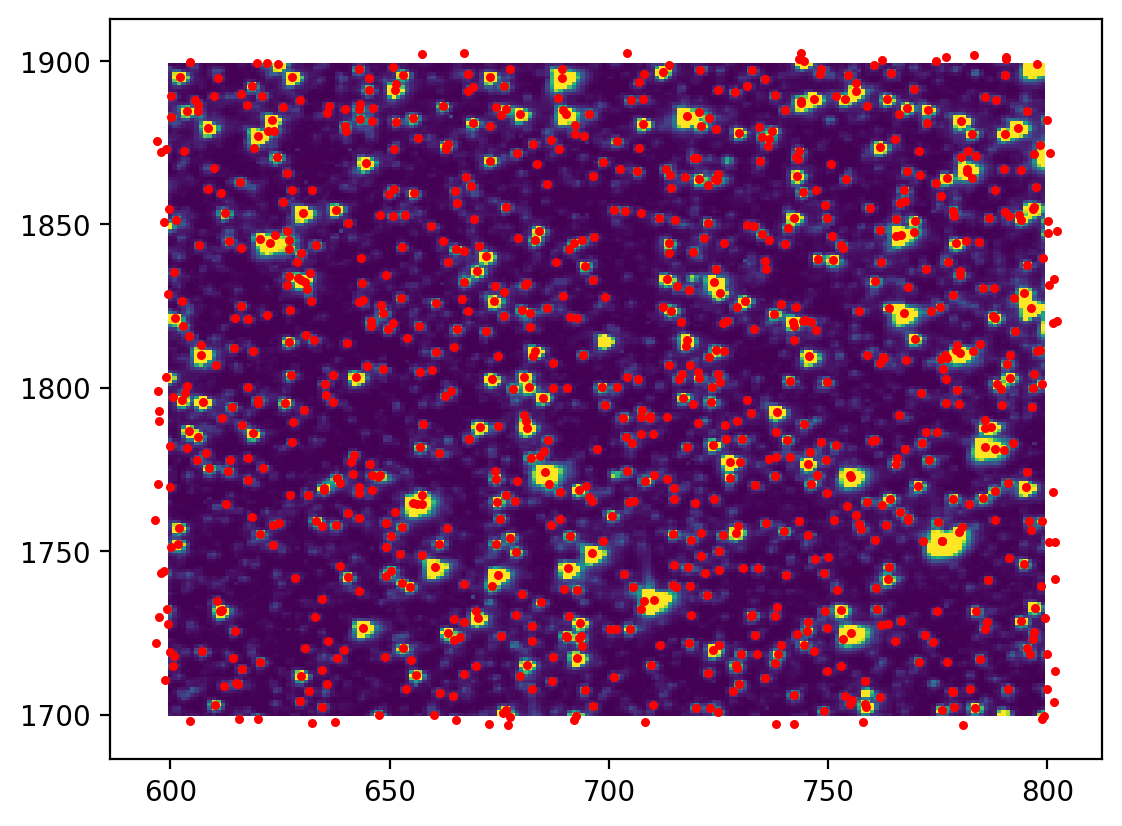

In [113]:
imp.reload(scene_fitter)
from scene_fitter import SceneFitter
# sf = SceneFitter(hdulist, df, cutout=cutout)
sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs)

# plot
# plt.imshow(sf.data, vmin=0, vmax=200)
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
plt.pcolormesh(R, C, sf.data, vmin=0, vmax=200)
bright_sources = sf.df.phot_rp_mean_flux > 1e4
plt.scatter(sf.df["X0"][bright_sources], sf.df["Y0"][bright_sources], s=5, c="r")

/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


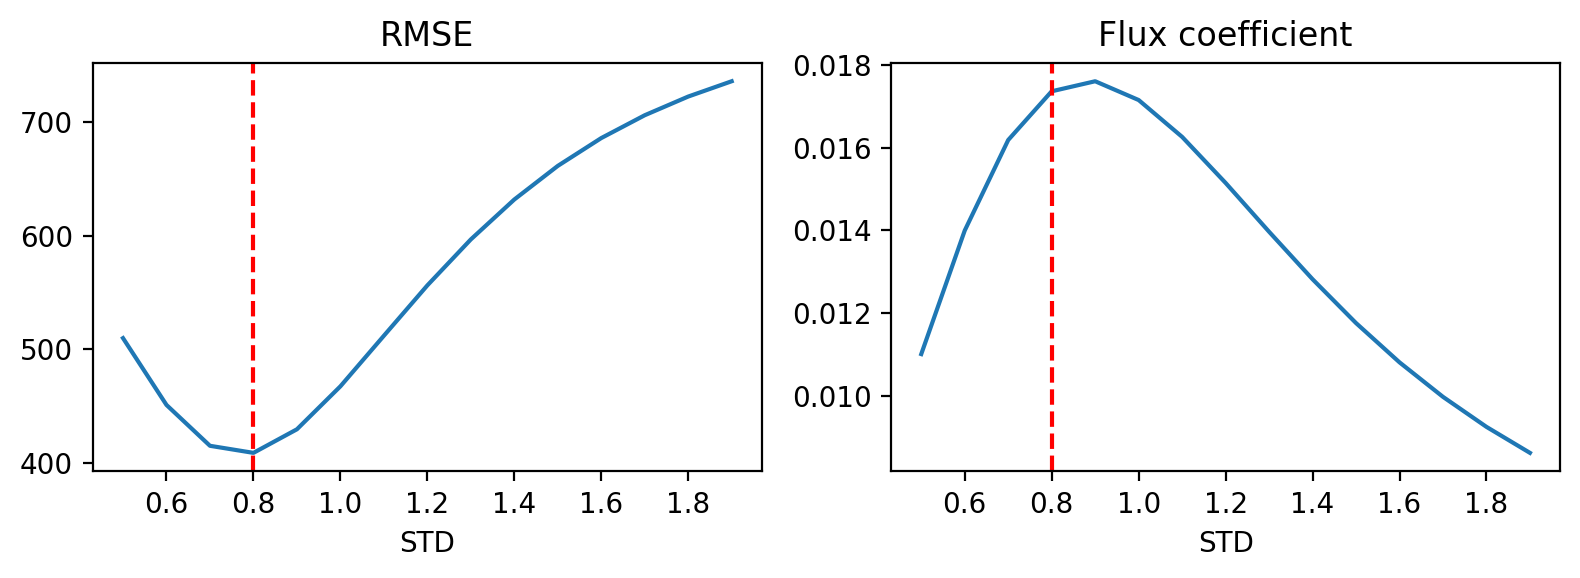

In [114]:
# initial flux coeff estimation
# flux_coeff, dx, dy, rmse = sf.fit_constant_flux_coeff()
sf.update_initial_flux_coeff(np.arange(0.5, 2., 0.1), plot=True)
gaia_flux_coeff = sf.gaia_flux_coeff
initial_std = sf.initial_std

# get the initial single source mask
ss_mask, single_source_data = sf.estimate_initial_ss_mask(tolerance=0.99, min_flux=50, update=True)

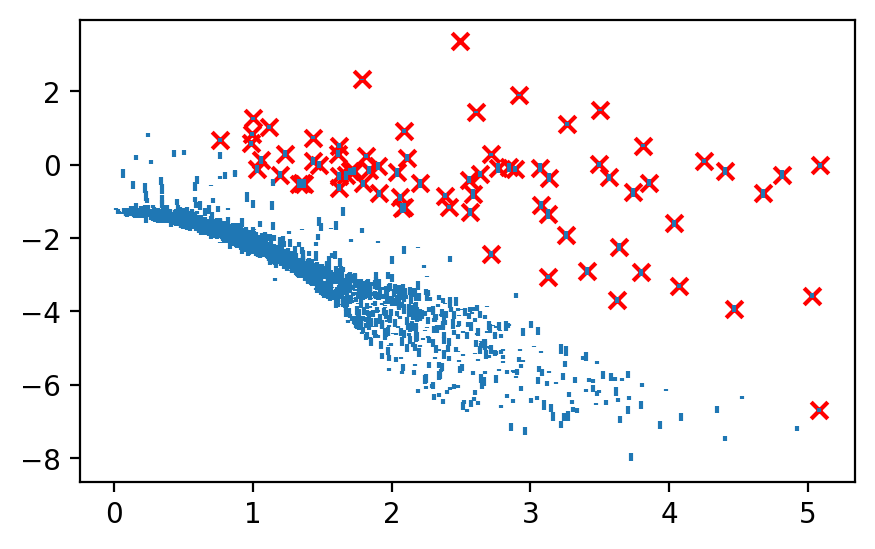

In [115]:
# get radial coordinates from initial psf
r, th, z, zerr, dx, dy = sf._convert_to_radial_coordinates()

# sigma clip those and apply the masks
k=4
_, _, sigma_mask = utils.iterative_sigma_clip(r, z, cenfunc=utils.custom_fit, sigma_clip_kwargs={'sigma_upper':5, 'sigma_lower':5}, cenfunc_kwargs={'n_bin':20, 'k':k, 'fit_func':utils.func_line})

# plot
plt.figure(figsize=[5,3])
plt.errorbar(r,z,zerr,linestyle='')
plt.scatter(r[~sigma_mask],z[~sigma_mask], c='r', marker='x')


r = r[sigma_mask]
th = th[sigma_mask]
z = z[sigma_mask]
zerr = zerr[sigma_mask]
dx = dx[sigma_mask]
dy = dy[sigma_mask]

/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/models/gaussian.py:99: RuntimeWarning: invalid value encountered in scalar power
  stddev_err = -(self.sigma[1])/(2 * np.sqrt(2) * self.mu[1] ** (3/2))
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


Core stddev:  (0.729971787856461, nan)
(1, 0.1)


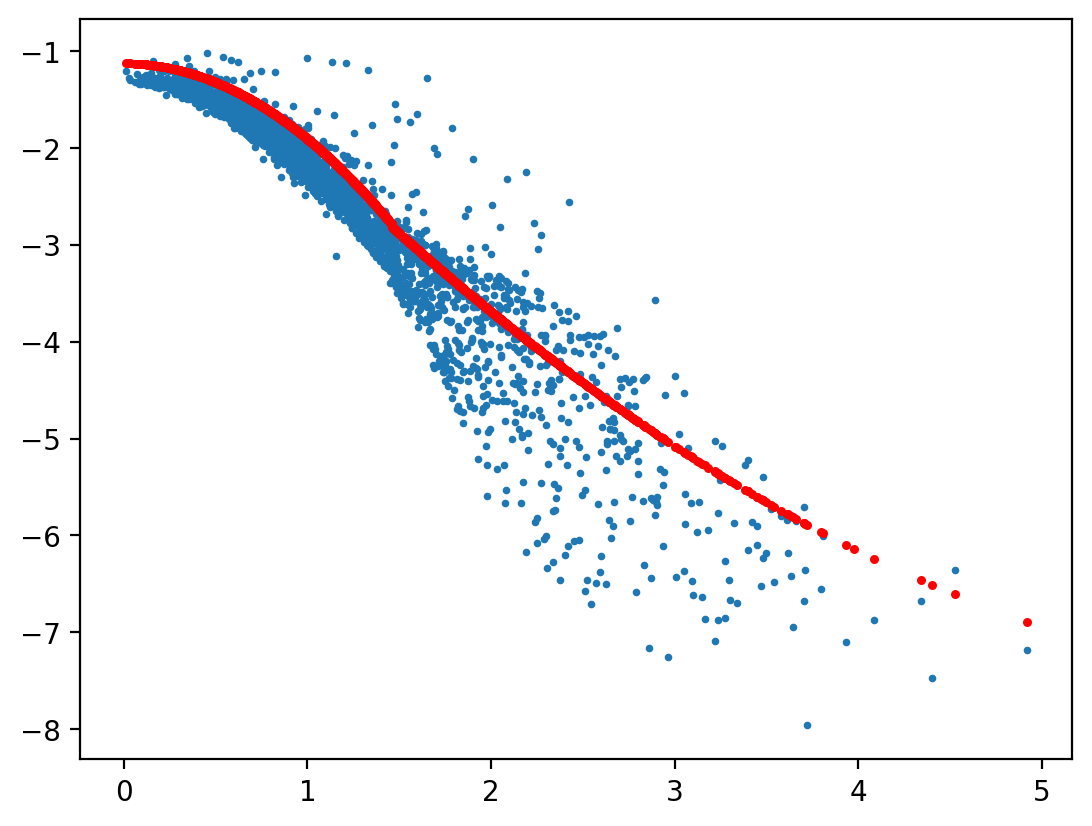

In [116]:
# Fit a gaussian to the core and line to the wings
core = (r < 1) & (z < -1)
wings = (r > 1) & (z < -1)

# add in sigma clip step in a bit
g1 = la.lnGaussian1DGenerator('r', stddev_prior=(1, .1))
# g1.fit(r=r, data=z, errors=zerr)
g1.fit(r=r[core], data=z[core], errors=zerr[core])
print("Core stddev: ", g1.stddev)

# Now do a bounded generator w/ updated core width
g2 = la.lnGaussian1DGenerator('r', stddev_prior=(g1.stddev[0], .1))
print(g1.stddev_prior)
g3 = la.Polynomial1DGenerator(x_name='r', polyorder=2)#, offset_prior=(0, 0))

# # systematics = p1 * p2
g_core = la.BoundedGenerator(g2, x_name='r', bounds=[(0, 2*g1.stddev[0])])
g_wings = la.BoundedGenerator(g3, x_name='r', bounds=[(2*g1.stddev[0], 100)])
combined = g_core + g_wings

# # g1.fit(r=r, data=z, errors=zerr)
# combined.fit(r=r[core], data=z[core])#, errors=zerr[core])
combined.fit(r=r, data=z, errors=zerr)

plt.scatter(r[z<-1], z[z<-1], s=3)
plt.scatter(r, combined.evaluate(r=r), c='r', s=5)
plt.show()


In [117]:
sf1 = sf.copy()
sf1.update_psf(combined)
# fig = sf1.plot_radial_psf()


/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:266: RuntimeWarning: invalid value encountered in log
  z = np.log((self.y / self.max_contributor_flux))


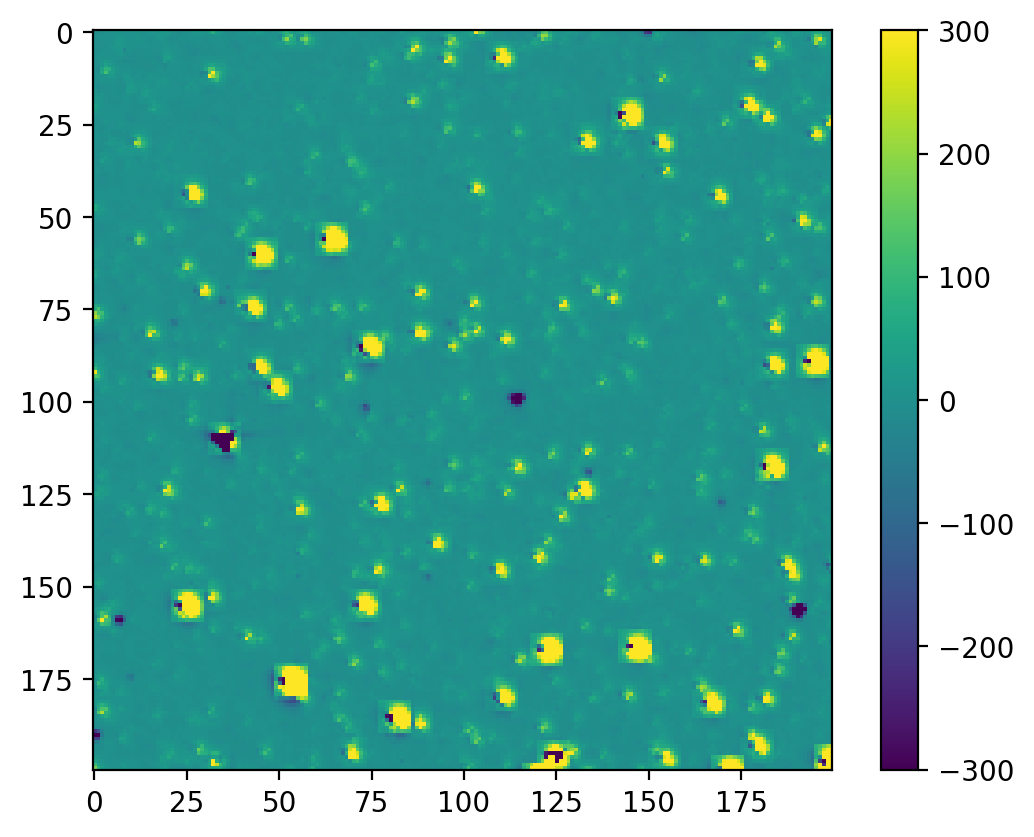

In [120]:
# plt.imshow(sf1.model_image)
plt.imshow(sf1.model_image - sf1.data, vmin=-300, vmax=300)
plt.colorbar()

In [119]:
# from scipy.stats import chisquare
def rmse(data, model):
    return np.sqrt(np.mean((data-model)**2))

rmse(sf1.data, sf1.model_image)
# print(len(sf1.data.ravel()), len(sf1.model_image.ravel()))
# chisquare(sf1.data.ravel(), sf1.model_image.ravel())

440.5721863747579

In [111]:
len(df)

534

In [ ]:
# 20 - 33, 5315086257.44
# 50 - 142, 24.071
# 100 - 60.24